this competition https://www.kaggle.com/c/departure-delayed/

In [1]:
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="white")
%matplotlib inline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import cross_val_score, GridSearchCV, StratifiedKFold
from scipy.sparse import csr_matrix, hstack
import lightgbm as lgb
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
%matplotlib inline

In [2]:
def rmse(y_test, y_pred):
    return np.sqrt(((y_test - y_pred) ** 2).mean())

def rmse_cv(estimator, X_test, y_test):
    """metrics for this competition"""
    return - np.sqrt(((estimator.predict(X_test) - y_test) ** 2).mean())

def rmse_log(estimator, X_test, y_test):
    """metrics for this competition"""
    return - np.sqrt(((np.exp(estimator.predict(X_test)) - np.exp(y_test)) ** 2).mean())

def submit_file(y_pred, filename):
    pd.Series(y_pred, name='DelayTime').to_csv('{}.csv'.format(filename), 
                                               index_label='id', header=True)
def hacking_score(pred, y_train):
    zeros_submit_score = 68.79140
    return pred + zeros_submit_score - np.sqrt(np.square(y_train.values).mean())

In [3]:
train_df = pd.read_csv('../input/train_features.csv')
test_df = pd.read_csv('../input/test_features.csv')
target = pd.read_csv('../input/train_target.csv', index_col='id')
train_df.head()

,Year,Month,DayofMonth,DayOfWeek,CRSDepTime,CRSArrTime,UniqueCarrier,FlightNum,TailNum,CRSElapsedTime,Origin,Dest,Distance
0,2008,4,23,3,700,907,US,1195,N119US,307.0,PHL,PHX,2075
1,2008,7,18,5,2154,2349,US,401,N637AW,115.0,PHX,SFO,651
2,2008,12,21,7,1921,1949,NW,1767,N782NC,88.0,DTW,MSN,312
3,2008,4,24,4,1955,2020,WN,1865,N272WN,145.0,SAT,PHX,843
4,2008,6,27,5,1700,1848,OH,5186,N804CA,108.0,ORF,CVG,485


In [4]:
train_df.shape, test_df.shape

((1355730, 13), (581028, 13))

In [5]:
train_df['DepHour'] = train_df['CRSDepTime'] // 100
train_df['DepHour'].replace(to_replace=24, value=0, inplace=True)
train_df['DepTime'] = train_df['DepHour'] + train_df['CRSDepTime'] % 100  / 60

test_df['DepHour'] = test_df['CRSDepTime'] // 100
test_df['DepHour'].replace(to_replace=24, value=0, inplace=True)
test_df['DepTime'] = test_df['DepHour'] + test_df['CRSDepTime'] % 100  / 60

train_df['ArrHour'] = train_df['CRSArrTime'] // 100
train_df['ArrHour'].replace(to_replace=24, value=0, inplace=True)
train_df['ArrTime'] = train_df['ArrHour'] + train_df['CRSArrTime'] % 100  / 60

test_df['ArrHour'] = test_df['CRSArrTime'] // 100
test_df['ArrHour'].replace(to_replace=24, value=0, inplace=True)
test_df['ArrTime'] = test_df['ArrHour'] + test_df['CRSArrTime'] % 100  / 60

test_df.drop(['CRSDepTime', 'CRSArrTime', 'Year', ], axis=1, inplace=True)
train_df.drop(['CRSDepTime', 'CRSArrTime', 'Year', ], axis=1, inplace=True)

train_df['target'] = target

In [6]:
train_df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,FlightNum,TailNum,CRSElapsedTime,Origin,Dest,Distance,DepHour,DepTime,ArrHour,ArrTime,target
0,4,23,3,US,1195,N119US,307.0,PHL,PHX,2075,7,7.000000,9,9.116667,15.0
1,7,18,5,US,401,N637AW,115.0,PHX,SFO,651,21,21.900000,23,23.816667,40.0
2,12,21,7,NW,1767,N782NC,88.0,DTW,MSN,312,19,19.350000,19,19.816667,31.0
3,4,24,4,WN,1865,N272WN,145.0,SAT,PHX,843,19,19.916667,20,20.333333,71.0
4,6,27,5,OH,5186,N804CA,108.0,ORF,CVG,485,17,17.000000,18,18.800000,15.0


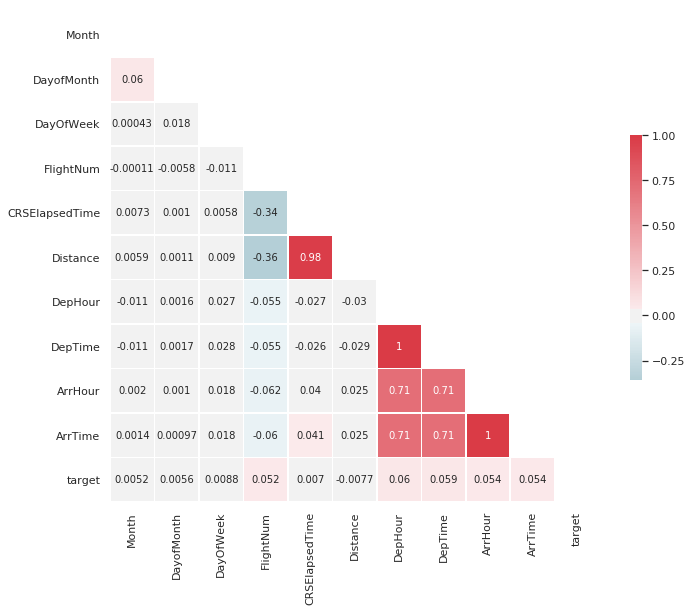

In [7]:
# Compute the correlation matrix
corr = train_df.iloc[:, [0,1,2,4,6, -6,-5,-4,-3,-2,-1]].corr()

# Generate a mask for the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

There are no strong correlations with target feature. But there is good correlation between _Distance_ and _CRSElapsedTime_. Drop _CRSElapsedTime_, it also has None values. 

In [8]:
test_df.drop(['CRSElapsedTime', ], axis=1, inplace=True)
train_df.drop(['CRSElapsedTime', ], axis=1, inplace=True)

In [9]:
# There are a little number (~5) of None in categorial column (TailNum), fill it!
train_df.fillna('EVIL', inplace=True)
test_df.fillna('EVIL', inplace=True)

In [10]:
train_df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,FlightNum,TailNum,Origin,Dest,Distance,DepHour,DepTime,ArrHour,ArrTime,target
0,4,23,3,US,1195,N119US,PHL,PHX,2075,7,7.000000,9,9.116667,15.0
1,7,18,5,US,401,N637AW,PHX,SFO,651,21,21.900000,23,23.816667,40.0
2,12,21,7,NW,1767,N782NC,DTW,MSN,312,19,19.350000,19,19.816667,31.0
3,4,24,4,WN,1865,N272WN,SAT,PHX,843,19,19.916667,20,20.333333,71.0
4,6,27,5,OH,5186,N804CA,ORF,CVG,485,17,17.000000,18,18.800000,15.0


In [11]:
test_df.head()

,Month,DayofMonth,DayOfWeek,UniqueCarrier,FlightNum,TailNum,Origin,Dest,Distance,DepHour,DepTime,ArrHour,ArrTime
0,2,14,4,NW,1221,N371NW,DTW,DEN,1123,12,12.366667,13,13.500000
1,1,13,7,FL,182,N974AT,ATL,DCA,547,21,21.166667,22,22.850000
2,7,22,2,EV,4154,N738EV,ALB,ATL,852,16,16.416667,19,19.000000
3,5,14,3,AA,1326,N523AA,STL,TPA,869,15,15.166667,18,18.333333
4,4,1,2,US,1910,N109UW,CLT,LGA,544,9,9.916667,11,11.883333


In [12]:
# train_df.target.plot.hist(bins=50)

In [13]:
# _ = plt.hist(np.log(train_df.target), bins=50)

In the future we will try to train model to predict log values, it is more normal

Some _FlightNum_s have long delay and some almost don't have

In [14]:
# train_df.FlightNum.nunique(), train_df.TailNum.nunique()

**Simple catboost**

In [15]:
# cbr = CatBoostRegressor(logging_level='Silent', random_state=45, 
#                         early_stopping_rounds=300, )

In [16]:
# simple catboost regressor without setup
# cbr.fit(train_df.drop('target', axis=1), target, cat_features=[0,1,2,3,4,5,6,7,9,11], plot=True)

In [17]:
# cb_pred = cbr.predict(test_df, verbose=True)

## Features creation

In [18]:
# train['week_high'] = ((train['DayOfWeek'].isin([4, 5, 1, 7]))).astype('int')

In [19]:
# plt.figure(figsize=(20, 10))
# sns.boxplot(data=train_df, x='DepHour', y='target',)

In [20]:
# train_df.groupby('DepHour').target.median().plot.bar()

In [21]:
OHE = OneHotEncoder(handle_unknown='ignore')

ohe_x_train = OHE.fit_transform(train_df.iloc[:, [0,1,2,3,4,5,6,7,9,11]])
num_x_train = train_df.iloc[:, [8, 10, 12]]

ohe_x_test = OHE.transform(test_df.iloc[:, [0,1,2,3,4,5,6,7,9,11]])
num_x_test = test_df.iloc[:, [8, 10, 12]]

X = hstack([ohe_x_train, num_x_train]).tocsr()
X_test = hstack([ohe_x_test, num_x_test]).tocsr()
y = train_df.target.values

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, random_state=46)

In [22]:
# lcv = cross_val_score(LinearRegression(), X, y, scoring=rmse_cv , cv=5, n_jobs=-1, verbose=1)
# lcv

In [23]:
X.shape, X_test.shape, y.shape

((1355730, 13575), (581028, 13575), (1355730,))

In [24]:
# cat_features=[0,1,2,3,4,5,6,7,9,11]
# dart mode


param = {'num_leaves': 200, 
         'objective': 'tweedie',
         'metric': 'rmse', 
         'verbosity' : 0, 
         'max_depth': -1, 
         'learning_rate': 0.01, 
         'num_threads': 4, 
#          'reg_alpha': 0.01, 
#          'reg_lambda': 3
}

def LGB_cv_scoring(X_train, y_train, X_test, num_round=5000, early_stopping_rounds=200, 
               verbose_eval=500, param=param, nfolds=5):
    
    predict = np.zeros(X_test.shape[0])
        
    oof = np.zeros(X_train.shape[0])
    folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=870)
    for fold_, (ind_trn, ind_valid) in enumerate(folds.split(X_train, y_train)):
        print("Fold {}".format(fold_))

        X_train_lgbm = lgb.Dataset(X_train[ind_trn], y_train[ind_trn])
        X_valid_lgbm = lgb.Dataset(X_train[ind_valid], y_train[ind_valid])

        clf = lgb.train(param, X_train_lgbm, num_round, 
                             valid_sets=[X_valid_lgbm], 
                             early_stopping_rounds=early_stopping_rounds, 
                             verbose_eval=verbose_eval)
        oof[ind_valid] = clf.predict(X_train[ind_valid], num_iteration = clf.best_iteration)
        
        pred = clf.predict(X_test, num_iteration=clf.best_iteration) / nfolds
        predict += pred  
    print("CV score: {:<8.5f}".format(rmse(y_train, oof)))
    return np.array(predict)

In [25]:
def CB_cv_scoring(X_train, y_train, X_test, nfolds=5):
    
    predict = np.zeros(X_test.shape[0])
        
    oof = np.zeros(X_train.shape[0])
    folds = StratifiedKFold(n_splits=nfolds, shuffle=True, random_state=870)
    for fold_, (ind_trn, ind_valid) in enumerate(folds.split(X_train, y_train)):
        print("Fold {}".format(fold_))

        clf = CatBoostRegressor(
            random_seed=42,
            logging_level='Silent',
            early_stopping_rounds=200,
        #     learning_rate=0.1,  
        )
        categorical_features_indices = [0,1,2,3,4,5,6,7,9,11]
        clf.fit(
            X_train.iloc[ind_trn], y_train.iloc[ind_trn],
            cat_features=categorical_features_indices,
            eval_set=(X_train.iloc[ind_valid], y_train.iloc[ind_valid]),
        #     logging_level='Verbose',  # you can uncomment this for text output
#             plot=True
        );

        oof[ind_valid] = clf.predict(X_train.iloc[ind_valid],)
        
        pred = clf.predict(X_test) / nfolds
        predict += pred  
    print("CV score: {:<8.5f}".format(rmse(y_train, oof)))
    return np.array(predict)

In [26]:
lgb_pred = LGB_cv_scoring(X, y, X_test)
submit_file(lgb_pred, 'lgb_pred')

Fold 0
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's rmse: 46.8333
[1000]	valid_0's rmse: 46.4032
[1500]	valid_0's rmse: 46.2316
[2000]	valid_0's rmse: 46.1204
[2500]	valid_0's rmse: 46.0517
[3000]	valid_0's rmse: 45.9973
[3500]	valid_0's rmse: 45.9558
[4000]	valid_0's rmse: 45.9232
[4500]	valid_0's rmse: 45.8941
[5000]	valid_0's rmse: 45.877
Did not meet early stopping. Best iteration is:
[5000]	valid_0's rmse: 45.877
Fold 1
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's rmse: 50.2889
[1000]	valid_0's rmse: 49.8977
[1500]	valid_0's rmse: 49.7573
[2000]	valid_0's rmse: 49.6517
[2500]	valid_0's rmse: 49.5673
[3000]	valid_0's rmse: 49.5076
[3500]	valid_0's rmse: 49.4585
[4000]	valid_0's rmse: 49.4266
[4500]	valid_0's rmse: 49.3986
[5000]	valid_0's rmse: 49.3784
Did not meet early stopping. Best iteration is:
[4998]	valid_0's rmse: 49.3783
Fold 2
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's 

In [27]:
cat_pred = CB_cv_scoring(train_df.drop('target', axis=1), train_df.target, test_df)
submit_file(cat_pred, 'cat_pred')

Fold 0
Fold 1
Fold 2
Fold 3
Fold 4
CV score: 47.69772


In [28]:
mix_pred = (lgb_pred + cat_pred) / 2
submit_file(mix_pred, 'mix_pred')

In [ ]:
hack_mix_pred = hacking_score(mix_pred, y)
submit_file(hack_mix_pred, 'hack_mix_pred')